- Change the np.load to include the file
- Add the following .pkl files into the same folder as this .ipynb (model, model_features, scaler, poly)
- Edit the transform_features() method if necessary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import joblib
import networkx as nx
import sys
import os

sys.path.append(os.path.abspath(".."))

test=np.load("../datasets/labeled/fourth_batch_multi_labels.npz")

X_test=test["X"]

XX_test = pd.DataFrame(X_test)
XX_test.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)

num_unique_users = XX_test["user"].nunique()
print(f"Number of unique user IDs in the test set: {num_unique_users}")

Number of unique user IDs in the test set: 1100


In [2]:
from utils.feature_transformation import aggregate_features
from sklearn.impute import SimpleImputer

test_features = aggregate_features(XX_test)
test_features.sort_values(by="user", inplace=True)

# Select only important features
model_features = joblib.load("model_features.pkl")
print(f"test_features before selecting features {test_features.shape}")

# If feature does not exist, populate with 0s
for feat in model_features:
    if feat not in test_features.columns:
        test_features[feat] = 0
test_features = test_features[model_features]
print(f"test_features after selecting features {test_features.shape}")

# debugging
print(test_features.columns)

scaler = joblib.load("scaler.pkl")
# poly = joblib.load("poly.pkl")

test_features_scaled = scaler.transform(test_features)
# test_features_poly = poly.transform(test_features_scaled)

# Load the trained model and predict probabilities (shape: #test_users x 6)
xgb_model = joblib.load("xgb_model.pkl")
probabilities = xgb_model.predict_proba(test_features_scaled)
y_pred_proba_rf = xgb_model.predict_proba(test_features_scaled)
# print(y_pred_proba_rf)

np.savez("predictions.npz", probabilities=probabilities)
print(f"prediction shape {probabilities.shape}")

test_results=np.load("predictions.npz")
test_results_df = pd.DataFrame(test_results["probabilities"])
test_results_df.head()

test_features before selecting features (1100, 89)
test_features after selecting features (1100, 56)
Index(['review_count', 'avg_rating', 'std_rating', 'like_count',
       'dislike_count', 'neutral_count', 'dislike_pct', 'unknown_pct',
       'neutral_pct', 'rating_entropy', 'rare_movies_watched_pct',
       'avg_movie_popularity', 'std_movie_popularity', 'min_movie_popularity',
       'max_movie_popularity', 'std_deviation', 'mean_abs_deviation',
       'max_abs_deviation', 'mean_rating_diff', 'std_rating_diff',
       'max_abs_rating_diff', 'rating_changes_pct', 'z_rating_max',
       'z_rating_median', 'z_rating_skew', 'likes_popular', 'likes_rare',
       'dislikes_popular', 'dislikes_rare', 'neutral_popular', 'neutral_rare',
       'unknown_popular', 'unknown_rare', 'interaction_entropy',
       'like_dislike_ratio', 'popularity_vs_deviation', 'min_movie',
       'max_movie', 'median_movie', 'variance_movie', 'sum_item_rating',
       'average_product', 'product_above_zero', 'sum

,0,1,2,3,4,5
0,0.178848,0.041106,0.507453,0.001638,0.048719,0.222235
1,0.999464,0.000057,0.000040,0.000008,0.000099,0.000333
2,0.994770,0.000789,0.000758,0.000186,0.002540,0.000957
3,0.988339,0.004481,0.000952,0.000076,0.001030,0.005121
4,0.989286,0.001608,0.001411,0.001683,0.002998,0.003013


In [3]:
data = np.load('predictions.npz')
predictions = data['probabilities']

class_counts = {i: 0 for i in range(6)}

for row in predictions:
    predicted_class = np.argmax(row)
    class_counts[predicted_class] += 1

print("Class instance counts:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count}") 

Class instance counts:
Class 0: 1055
Class 1: 0
Class 2: 3
Class 3: 14
Class 4: 14
Class 5: 14


In [4]:
from sklearn.metrics import roc_auc_score

y_true = test["y"]

# Convert true labels to a DataFrame
df_y_true = pd.DataFrame(y_true, columns=["user", "true_label"])

# Load the predicted probabilities
predictions_data = np.load("predictions.npz")
probabilities = predictions_data["probabilities"]

predicted_labels = np.argmax(probabilities, axis=1)

df_predictions = pd.DataFrame({
    "user": df_y_true["user"],
    "true_label": df_y_true["true_label"],
    "predicted_label": predicted_labels
})

# Identify misclassified users
df_predictions["correct"] = df_predictions["true_label"] == df_predictions["predicted_label"]
df_misclassified = df_predictions[df_predictions["correct"] == False]
# df_misclassified.head(2)
# df_misclassified.to_csv("misclassified_users.csv", index=False)

auc_per_class = {}
for i in range(probabilities.shape[1]):
    binary_true = (df_predictions["true_label"] == i).astype(int)
    try:
        auc = roc_auc_score(binary_true, probabilities[:, i])
        auc_per_class[i] = auc
        print(f"  Class {i}: AUC = {auc:.3f}")
    except ValueError:
        auc_per_class[i] = None

k = 5
AUC_0 = auc_per_class[0]
anomaly_aucs = [auc_per_class[i] for i in range(1, k+1) if i in auc_per_class]

final_metric = (0.5 * AUC_0) + (0.5 / k) * sum(anomaly_aucs)
print(f"\n🏆 Final Evaluation Metric: {final_metric:.3f}")

# Convert AUC scores to DataFrame
df_auc = pd.DataFrame(list(auc_per_class.items()), columns=["class", "AUC"])


  Class 0: AUC = 0.939
  Class 1: AUC = 0.819
  Class 2: AUC = 0.928
  Class 3: AUC = 0.975
  Class 4: AUC = 0.946
  Class 5: AUC = 0.917

🏆 Final Evaluation Metric: 0.928


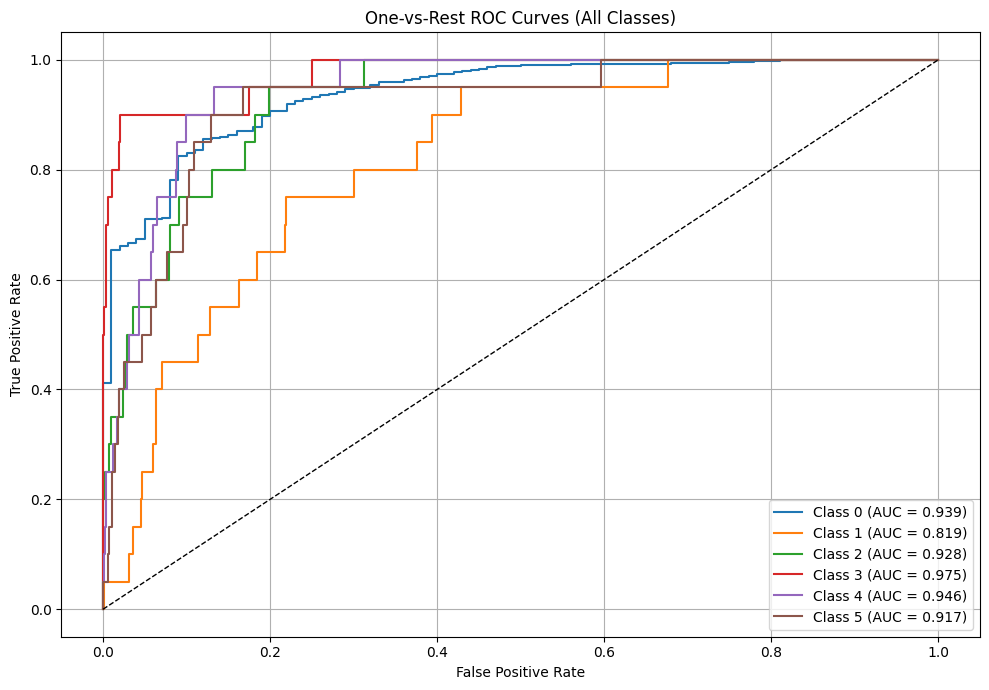

In [5]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for i in range(probabilities.shape[1]):
    y_true_binary = (df_predictions["true_label"] == i).astype(int)
    try:
        fpr, tpr, _ = roc_curve(y_true_binary, probabilities[:, i])
        auc = auc_per_class[i]
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.3f})")
    except ValueError:
        continue

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves (All Classes)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
